In [29]:
#Load the libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud
import re

from plotly.subplots import make_subplots
import gensim
from nltk.corpus import stopwords
from collections import Counter
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,f1_score
import plotly.express as px
import plotly.graph_objects as go
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df=pd.read_csv('/content/drive/MyDrive/Training_Datasets/Twitter Sentiment Analysis/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Training_Datasets/Twitter Sentiment Analysis/test.csv')
df.head(4)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...


# **EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
print('shape of train dataset',df.shape)
df.label.value_counts()

shape of train dataset (31962, 3)


0    29720
1     2242
Name: label, dtype: int64

In [5]:
# create a countplot of the "label" column. 
#It visualizes the distribution of class labels in the dataset, specifically for tweets.


fig = px.histogram(df, x='label', color='label')
fig.update_layout(xaxis_title='Class Label', yaxis_title='Number of Tweets')
fig.show()

In [13]:
#Visualizing the classes of train data
chat_data = df['label'].value_counts()

labels = ['Negative Class', 'Positive Class']

fig = go.Figure(data=[go.Pie(labels=labels, values=chat_data.values, textinfo='percent', hole=0.4)])

fig.update_layout(title='Class Distribution')

fig.show()

- Negative tweets which reflects racism or sexism are relatively lesser in number.
- Due to this class imbalance, Accuracy may not be a good option for checking performance of our models. Instead, confusion matrix can be a good option.

In [21]:
def preprocess_tweets(df_series):
    """ Removes account tags (@user) and all non-alphanumeric characters except whitespace.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        
    Returns: 
        df_series (pd.series): Preprocessed series object. 
    """
    
    # Removes '@user' tags
    df_series = df_series.str.replace("@user", "", regex=False)
    
    # Removes non alphanumeric characters
    df_series = df_series.str.replace("[^a-zA-Z0-9 ]", " ")
    return df_series
    

def tokenize(sentence, remove_stopwords=False):
    """ Tokenizes given sentence.
        
    Args:
        sentence (str): Sentence to be tokenized
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        tokens (list): Tokenized array
    """
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = sentence.split()
        tokens = [token for token in tokens if not token.lower() in stop_words]
        return tokens
        
    return sentence.split()

In [22]:
def create_ner_dict(df_series):
    """ Creates and returns dictionary having text phrases and their named entity.
    
    Args:
        df_series (pd.series): Pandas series object containing sentences.
    
    Returns:
        NER_dict (dict): Dictionary of text phrases from sentences of df_series and 
                         corresponding named entities.
    """
    
    NER = spacy.load("en_core_web_sm")
    NER_dict = {"text": [], "named_entity":[]}
    
    # Preprocessing tweets
    preprocessed_tweets = preprocess_tweets(df_series)
    
    # Removing stop words and creating named entity recognition dict
    for tweet in preprocessed_tweets:
        sentence = tokenize(tweet, remove_stopwords=True)
        sentence = ' '.join(map(str, sentence))
        doc = NER(sentence)
        NER_dict["text"].extend([token.text for token in doc.ents])
        NER_dict["named_entity"].extend([token.label_ for token in doc.ents])
        
    return NER_dict

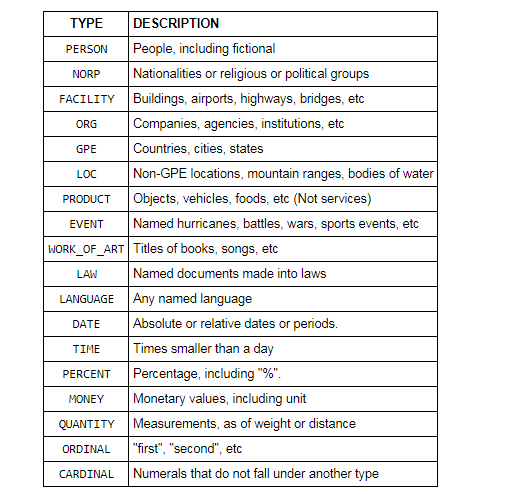

In [23]:
# Named entity recognition of tweets of different categories
non_offensive_NER_dict = create_ner_dict(df[df["label"]==0].tweet)
offensive_NER_dict = create_ner_dict(df[df["label"]==1].tweet)

In [24]:
# Converting to DataFrame
non_offensive_NER_df = pd.DataFrame.from_dict(non_offensive_NER_dict)
offensive_NER_df = pd.DataFrame.from_dict(offensive_NER_dict)

In [25]:
# Displaying sample observations
display(non_offensive_NER_df.head())
display(offensive_NER_df.head())

,text,named_entity
0,2 2,CARDINAL
1,next school year year,DATE
2,2,CARDINAL
3,orlando,GPE
4,today,DATE


,text,named_entity
0,cnn,ORG
1,michigan,GPE
2,comment australia,ORG
3,lumpy,PERSON
4,21st century,DATE


<Axes: ylabel='named_entity'>

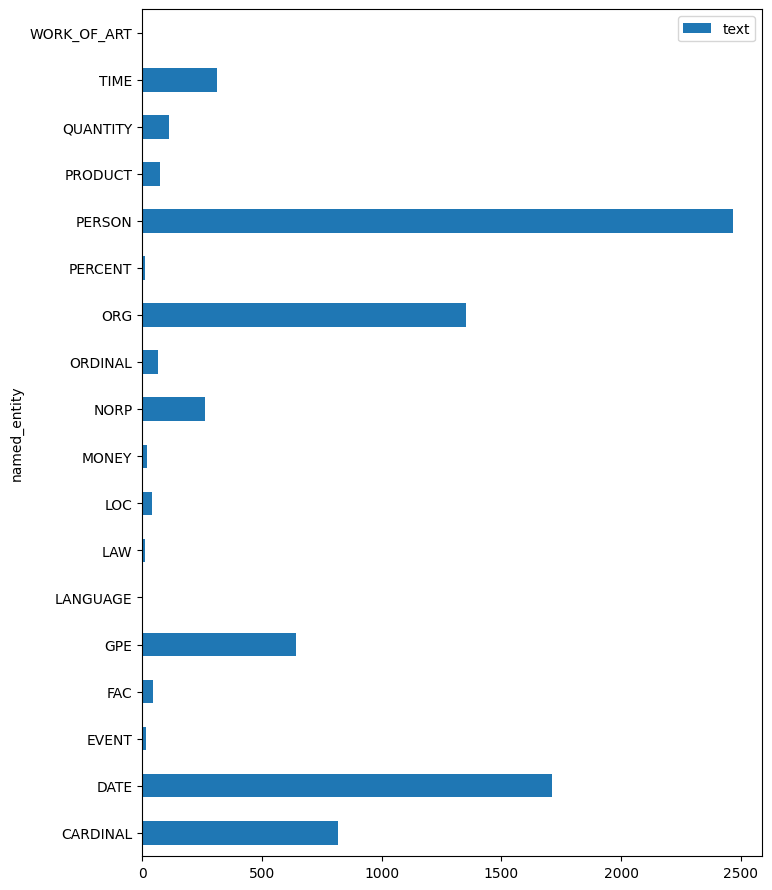

In [26]:
# Plotting named entities mentioned most times in Non-Offensive tweets
non_offensive_NER_df.groupby("named_entity").agg({"text": pd.Series.nunique}).plot.barh(figsize=(8,11))

<Axes: ylabel='named_entity'>

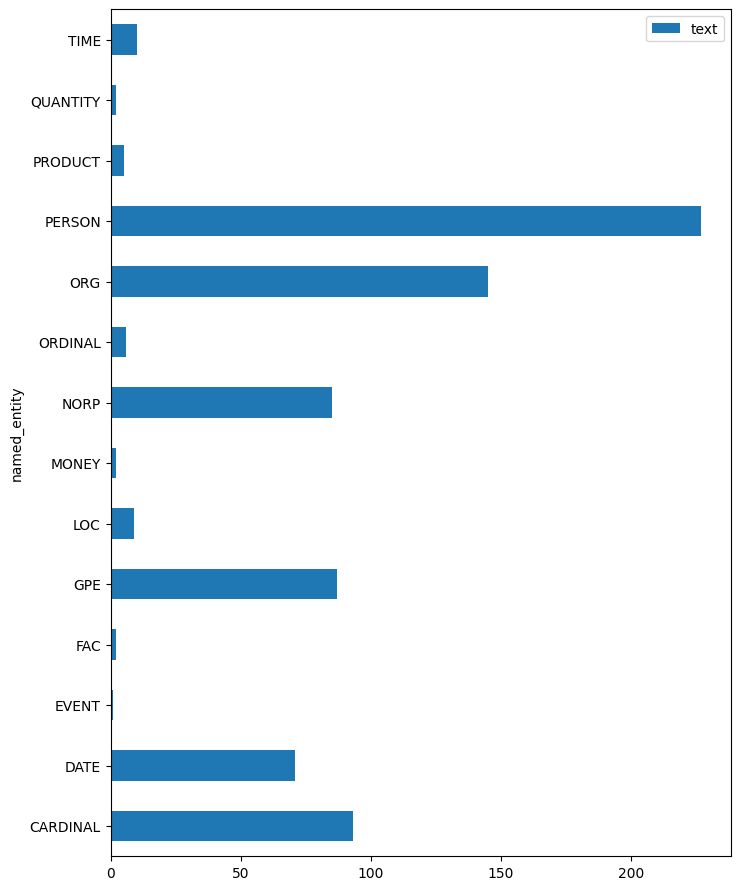

In [27]:
# Plotting named entities mentioned most times in Offensive tweets
offensive_NER_df.groupby("named_entity").agg({"text": pd.Series.nunique}).plot.barh(figsize=(8,11))

Based on the visualization, we can observe that a significant portion of the tweets revolves around particular individuals or organizations. Additionally, offensive content in tweets tends to target specific individuals, organizations, nationalities, religious groups, or political entities. This suggests that there is a tendency for tweets to focus on and potentially criticize or attack specific entities or groups.

In [30]:
# Creates new df containing count of text by each named entity of Non offensive tweets
non_offensive_NER_text_occurances = non_offensive_NER_df.groupby("named_entity").agg({"text": list})
non_offensive_NER_text_occurances["text_counts"] = non_offensive_NER_text_occurances.agg({"text": Counter})["text"]

In [31]:
display(non_offensive_NER_text_occurances)

,text,text_counts
named_entity,,
CARDINAL,"[2 2, 2, 80, 45, 50, 1, one, 2, 15, 7 99, 1 14...","{'2 2': 5, '2': 317, '80': 12, '45': 3, '50': ..."
DATE,"[next school year year, today, friday, badday,...","{'next school year year': 1, 'today': 914, 'fr..."
EVENT,"[deva day, vietnam, weekend yoga sea, hugo, to...","{'deva day': 1, 'vietnam': 2, 'weekend yoga se..."
FAC,"[orlando america, newelectricscrewdriver brock...","{'orlando america': 1, 'newelectricscrewdriver..."
GPE,"[orlando, got7, orlando, poland, florida, orla...","{'orlando': 367, 'got7': 3, 'poland': 20, 'flo..."
LANGUAGE,"[english, english, english, filipino, anna, en...","{'english': 14, 'filipino': 1, 'anna': 1, 'wes..."
LAW,[euro 2016 bbc pundits make predictions france...,{'euro 2016 bbc pundits make predictions franc...
LOC,"[europe, europe, europe, euro2016 england, eur...","{'europe': 19, 'euro2016 england': 3, 'caribbe..."
MONEY,"[number marks, 1struggle, 70, lgbt, 70 bucks, ...","{'number marks': 1, '1struggle': 1, '70': 1, '..."


In [32]:
# Creates new df containing count of text by each named entity of Offensive tweets
offensive_NER_text_occurances = offensive_NER_df.groupby("named_entity").agg({"text": list})
offensive_NER_text_occurances["text_counts"] = offensive_NER_text_occurances.agg({"text": Counter})["text"]

In [33]:
def sort_dict_by_value(dictionary, reverse=False):
    """ Returns list of (value, key) tuples sorted by value.
    
    Args:
        dictionary (dict): Dict of key, value pairs.
        reverse (bool): Sorts in descending order if set True. Defaults to False
        
    Returns:
        list: Contains (value, key) tuples sorted by value
    """
    
    return sorted(
        dict((value, key) for (key, value) in dictionary.items()).items(),
        reverse=reverse
    )


def max_val_of_dict(dictionary):
    """ Returns list containing maximum value and its corresponding 
        key in a dict.
        
    Args:
        dictionary (dict): Dict of key, value pairs.
            
    Returns:
        list: Contains corresponding key of maximum value in the dictionary
              and the maximum value itself.
    """
    
    max_key = max(dictionary, key=dictionary.get)
    max_value = dictionary[max_key]
    
    return [max_key, max_value]

In [34]:
# displays highest repeated text by each named entity in Non offensive tweets
n_rows, n_cols = non_offensive_NER_text_occurances.shape

for i in range(n_rows):
    non_offensive_NER_text_occurances["text_counts"][i] = sort_dict_by_value(
                                                                non_offensive_NER_text_occurances["text_counts"][i],
                                                                reverse=True
                                                            )

non_offensive_NER_text_occurances.reset_index(inplace=True)
display(non_offensive_NER_text_occurances)

,named_entity,text,text_counts
0,CARDINAL,"[2 2, 2, 80, 45, 50, 1, one, 2, 15, 7 99, 1 14...","[(454, one), (317, 2), (232, 3), (167, 4), (14..."
1,DATE,"[next school year year, today, friday, badday,...","[(914, today), (412, friday), (391, summer), (..."
2,EVENT,"[deva day, vietnam, weekend yoga sea, hugo, to...","[(2, wimbledon), (1, world cup)]"
3,FAC,"[orlando america, newelectricscrewdriver brock...","[(3, season4 episode13), (2, girona gerona), (..."
4,GPE,"[orlando, got7, orlando, poland, florida, orla...","[(367, orlando), (127, london), (67, america),..."
5,LANGUAGE,"[english, english, english, filipino, anna, en...","[(14, english), (1, westafrica)]"
6,LAW,[euro 2016 bbc pundits make predictions france...,"[(1, rico)]"
7,LOC,"[europe, europe, europe, euro2016 england, eur...","[(19, europe), (5, asia), (4, caribbean), (3, ..."
8,MONEY,"[number marks, 1struggle, 70, lgbt, 70 bucks, ...","[(3, 2), (2, lgbt), (1, 1 4 bless)]"
9,NORP,"[hawaiian, japanese, muslim, bithday27, republ...","[(36, americans), (33, american), (29, muslim)..."


In [35]:
# displays highest repeated text by each named entity in Offensive tweets
n_rows, n_cols = offensive_NER_text_occurances.shape

for i in range(n_rows):
    offensive_NER_text_occurances["text_counts"][i] = sort_dict_by_value(
                                                                offensive_NER_text_occurances["text_counts"][i],
                                                                reverse=True
                                                            )

offensive_NER_text_occurances.reset_index(inplace=True)

display(offensive_NER_text_occurances)

,named_entity,text,text_counts
0,CARDINAL,"[7, 75, 60, 2, 2016in4worlds 2016in4words, one...","[(43, 2), (34, one), (22, 4), (14, 2016in4word..."
1,DATE,"[21st century, 2016, 25 jan, next week, 8 year...","[(37, 2017), (31, 2016), (15, daily), (13, tod..."
2,EVENT,[wwii],"[(1, wwii)]"
3,FAC,"[southafrica crime fa, alabama st south long n...","[(1, alabama st south long ncaa dollars roll)]"
4,GPE,"[michigan, america, miami, pittsburgh, califor...","[(40, miami), (35, america), (27, calgary), (1..."
5,LOC,"[asia asians, far europe, africa, africa, asia...","[(3, africa), (1, europe apostolis)]"
6,MONEY,"[multi million dollar, 2016in4word, multi mill...","[(2, multi million dollar), (1, 2016in4word)]"
7,NORP,"[republican, african american, nazi, nazis, am...","[(29, hispanic), (19, americans), (16, muslims..."
8,ORDINAL,"[first, first, 5th, first, first, first, 1st, ...","[(13, first), (2, 14th), (1, second)]"
9,ORG,"[cnn, comment australia, codeword, cleveland p...","[(15, cnn), (10, gop), (7, anc), (6, bbc), (5,..."


In [36]:
# These are the named entities that we want to explore further
req_entities = ["EVENT", "GPE", "LANGUAGE", "NORP", "ORG"]
n_req_entities = len(req_entities)

In [39]:
# Visualizes most repetetive Non offensive text phrases from each named entity


fig = make_subplots(rows=n_req_entities, cols=1, subplot_titles=[f"Entity: {entity}" for entity in req_entities])

for i, entity in enumerate(req_entities):
    x, y = list(zip(*non_offensive_NER_text_occurances[non_offensive_NER_text_occurances["named_entity"] == entity]["text_counts"].values[0][:5]))
    fig.add_trace(go.Bar(y=y, x=x, orientation='h', marker=dict(color='green')), row=i+1, col=1)
    fig.update_yaxes(title_text="Text phrase", row=i+1, col=1, showticklabels=False)
    fig.update_xaxes(title_text="Count", row=i+1, col=1)
    fig.update_layout(height=800, width=1000, title="Frequent text (Non offensive) grouped by each entity")

fig.show()


In [41]:
fig = make_subplots(rows=n_req_entities, cols=1, subplot_titles=[f"Entity: {entity}" for entity in req_entities])

fig = make_subplots(rows=n_req_entities, cols=1, subplot_titles=[f"Entity: {entity}" for entity in req_entities])

for i, entity in enumerate(req_entities):
    if entity in offensive_NER_text_occurances["named_entity"].values:
        x, y = list(zip(*offensive_NER_text_occurances[offensive_NER_text_occurances["named_entity"] == entity]["text_counts"].values[0][:5]))
        fig.add_trace(go.Bar(y=y, x=x, orientation='h', marker=dict(color='crimson')), row=i+1, col=1)
        fig.update_yaxes(title_text="Text phrase", row=i+1, col=1, showticklabels=False)
        fig.update_xaxes(title_text="Count", row=i+1, col=1)
        fig.update_layout(height=800, width=1000, title="Frequent text (Offensive) grouped by each entity")
    else:
        fig.add_trace(go.Bar(y=[], x=[], orientation='h', marker=dict(color='crimson')), row=i+1, col=1)
        fig.update_yaxes(title_text="Text phrase", row=i+1, col=1, showticklabels=False)
        fig.update_xaxes(title_text="Count", row=i+1, col=1)
        fig.update_layout(height=800, width=1000, title="Frequent text (Offensive) grouped by each entity")

fig.show()

The visualizations reveal the most frequent words associated with each named entity, categorized accordingly. By examining these visualizations, we can gain valuable insights into the prominent terms used in relation to specific entities. This analysis allows us to better understand the language and context surrounding each named entity, providing deeper insights into the discussions and topics associated with them.

# **Visualizing top mentioned hashtags under each category¶**
Hashtags often provide valuable insights as they encapsulate the essence of an entire tweet in a single word or convey information about the person, place, or topic discussed. By analyzing hashtags, we can uncover meaningful trends and themes within a dataset, gaining a deeper understanding of the conversations and topics of interest.

In [43]:
def get_hash_tags(df_series):
    """ Collects all hash tags from a given pandas series.
    
    Args:
        df_series (pd.Series): Pandas series object containing text data.
    
    Returns:
        hash_tags (list): List of hash tags from the pandas series.
    """
    
    hash_tags = []
    for text in df_series:
        hash_tags.extend(re.findall(r'#(\w+)', text))
        
    return hash_tags

In [44]:
non_offensive_hashtags = get_hash_tags(df[df["label"]==0]["tweet"])
offensive_hashtags = get_hash_tags(df[df["label"]==1]["tweet"])

In [46]:
def plot_word_cloud(corpus):
    """ Creates and plots the word cloud from word corpus.
        
    Args:
        corpus (list): word corpus containing all the tokens.
        
    Returns: Nothing
    
    """
    
    # creates word cloud
    word_cloud = WordCloud(
        max_words = 100,
        max_font_size = 50,
        collocations = False
    ).generate(str(corpus))
    
    # plots word cloud
    fig = plt.figure(figsize=(13, 13))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.plot()

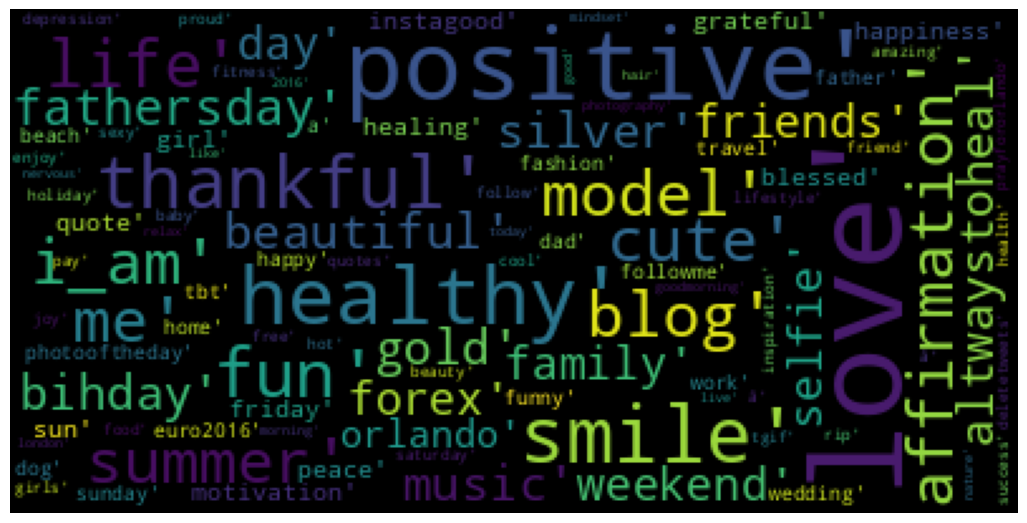

In [47]:
# Word cloud of top mentioned hashtags in Non-offensive tweets
plot_word_cloud(non_offensive_hashtags)

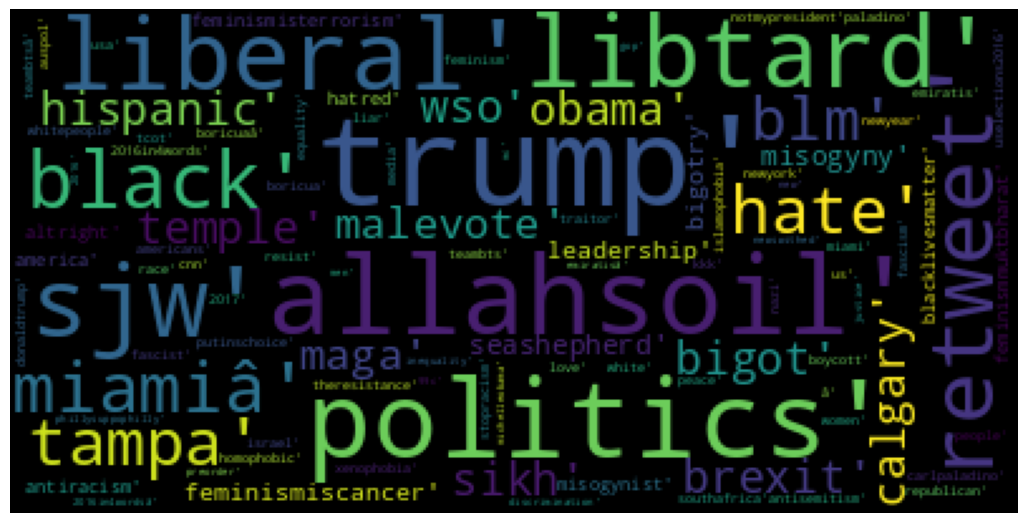

In [48]:
# Word cloud of top mentioned hashtags in Offensive tweets
plot_word_cloud(offensive_hashtags)

In [49]:
# Count of each hashtags
non_offensive_hashtag_counts = Counter(non_offensive_hashtags)
offensive_hashtag_counts = Counter(offensive_hashtags)

In [50]:
# Creating hashtag counts DataFrame for easy manipulation and visualization

non_offensive_hashtag_counts_df = pd.DataFrame.from_dict(non_offensive_hashtag_counts, orient="index").reset_index()
non_offensive_hashtag_counts_df.columns = ["hashtag", "count"]
non_offensive_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(non_offensive_hashtag_counts_df.head())

offensive_hashtag_counts_df = pd.DataFrame.from_dict(offensive_hashtag_counts, orient="index").reset_index()
offensive_hashtag_counts_df.columns = ["hashtag", "count"]
offensive_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(offensive_hashtag_counts_df.head())

,hashtag,count
33,love,1531
41,positive,874
163,healthy,570
212,smile,548
40,thankful,491


,hashtag,count
22,trump,133
31,politics,94
67,allahsoil,92
28,libtard,76
30,liberal,75


In [51]:
# Bar plot of top hashtag counts in Non-offensive tweets 

fig = go.Figure()

fig.add_trace(go.Bar(
y=non_offensive_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten(),
x=non_offensive_hashtag_counts_df.head(50)['count'],
orientation='h',
marker=dict(color='blue')
))

fig.update_layout(
title="Top Hashtag Counts in Non-offensive Tweets",
xaxis_title="Counts",
yaxis_title="Hashtag",
height=700,
width=800
)

fig.show()

The above visualization provides insights into the most frequently used hashtags in non-offensive tweets. By examining the bar plot, we can identify the hashtags that occur most frequently and gain a better understanding of the common themes and topics associated with non-offensive discussions on the platform. This analysis allows us to uncover the prevalent hashtags used in positive or neutral conversations and helps us grasp the popular subjects of interest within this category.

In [52]:
# Bar plot of top hashtag counts in Offensive tweets 
fig = go.Figure()

fig.add_trace(go.Bar(
y=offensive_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten(),
x=offensive_hashtag_counts_df.head(50)['count'],
orientation='h',
marker=dict(color='crimson')
))

fig.update_layout(
title="Top Hashtag Counts in Offensive Tweets",
xaxis_title="Counts",
yaxis_title="Hashtag",
height=700,
width=800
)

fig.show()


The visualization above showcases the top hashtags that are most commonly used in offensive tweets. By analyzing the bar plot, we can identify the hashtags that occur with the highest frequency, providing valuable insights into the prevalent themes and topics associated with offensive discussions on the platform. This analysis helps us gain a deeper understanding of the hashtags used in negative or inflammatory conversations, enabling us to identify the key subjects and issues that are often targeted in offensive tweets.

# **What proportion of tweets contains a hashtag?**

In [53]:
def count_rows_with_hashtag(df_series):
    """ Counts the number of rows containing at least one hashtag (#example).
    
    Args:
        df_series (pd.Series): Pandas series containing text data.
        
    Returns:
        count (int): Count of number of rows containing at least one hashtag.
    """
    
    count = 0
    for tweet in df_series:
        if re.search(r'#(\w+)', tweet):
            count+=1
    
    return count

In [55]:
# Counts number of rows containing a hashtag
hashtag_tweet_count = count_rows_with_hashtag(df["tweet"])
train_rows, train_cols = df.shape

fig = go.Figure(data=[go.Pie(labels=["With hashtag", "Without hashtag"],
values=[hashtag_tweet_count, train_rows - hashtag_tweet_count],
hole=0.4,
marker=dict(colors=["#1AC9E6", "#1DE4BD"]),
hoverinfo="label+percent",
)])

fig.update_layout(title="Distribution of Tweets with and without Hashtags",
height=600,
width=600)

fig.show()

The pie chart above highlights the prevalence of hashtags in the dataset, indicating that a significant portion of tweets contains hashtags. This observation holds valuable implications for tweet classification tasks, as hashtags can serve as useful features in improving the accuracy of classification models. By incorporating hashtags as additional information, we can enhance the classification process and achieve more accurate predictions.

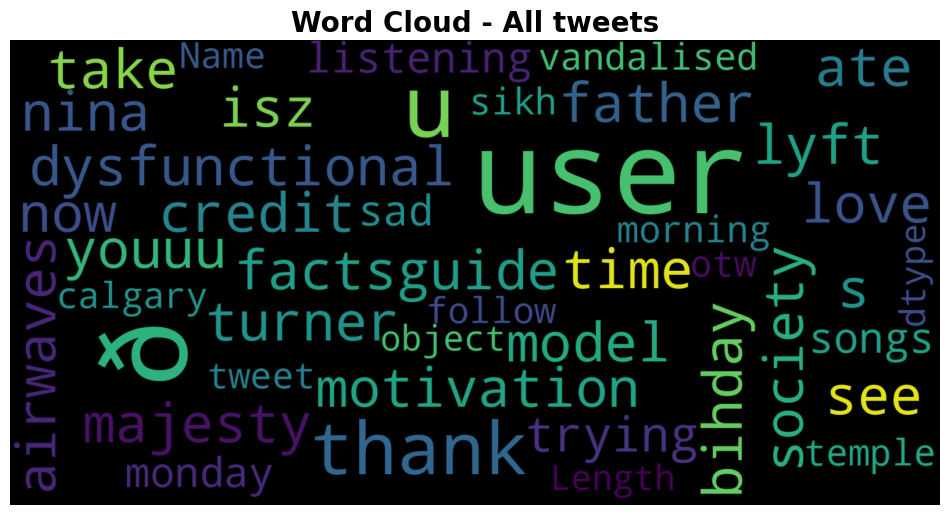

In [9]:
#Word cloud of all tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(str(df['tweet']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - All tweets',fontsize=20,fontweight='bold')
plt.show()

Here are some key observations about the dataset:

- Dataset Columns: The dataset consists of three columns: "id", "label", and "tweet". The "id" column is not relevant for the classification task. The "tweet" column contains the actual text of the tweets, and the "label" column represents the category or class of each tweet.

- Null Values: There are no null values present in the dataset, ensuring data completeness.

- Category Distribution: The distribution of categories reveals that approximately 7.01% of the tweets are classified as offensive, while the majority, 92.99%, are categorized as not offensive.

- Token Distribution: Most of the tweets in the dataset contain around 5 to 20 tokens. The interquartile range (25th to 75th percentile) of the token count ranges from 9 to 17 tokens, with a median of 13 tokens. The maximum length of any tweet in the dataset is less than 35 tokens.

- Common Words in Offensive Tweets: Words such as "racist," "black," "hate," and "race" appear frequently in offensive tweets, indicating the presence of highly relevant and discriminative terms.

- Topic Specificity: The analysis suggests that tweets often revolve around specific individuals, organizations, or entities. This indicates that the content of the tweets tends to focus on particular subjects or targets.

- Offensiveness Targets: Offensive tweets predominantly target specific individuals, followed by organizations, religious groups, and political parties. This finding provides insights into the primary recipients or themes of offensive content.

- Hashtag Analysis: The most frequent hashtags in non-offensive tweets include "#love," "#positive," "#healthy," "#smile," and "#thankful," reflecting positive sentiments and topics. In contrast, hashtags in offensive tweets such as "#black," "#hate," "#feminismiscancer," "#feminismisterrorism," "#hatred," and "#race" convey offensive or provocative themes.

- Hashtag Usage: Around 73.39% of the tweets contain at least one hashtag, highlighting their prevalence and potential usefulness in improving model performance. Conversely, 26.61% of the tweets do not include any hashtags.

By considering these insights, we can leverage the distribution of categories, token analysis, target specificity, and hashtag usage to develop more accurate models for tweet classification tasks.

In [ ]:


# Class 1 histogram
fig1 = go.Figure(data=[go.Histogram(x=df[df['label']==1].tweet.str.len(), nbinsx=20, name='Class 1')])
fig1.update_layout(xaxis_title='Length of Tweets', yaxis_title='Number of Tweets', showlegend=True)
fig1.show()

# Class 0 histogram
fig0 = go.Figure(data=[go.Histogram(x=df[df['label']==0].tweet.str.len(), nbinsx=20, name='Class 0', marker=dict(color='yellow'))])
fig0.update_layout(xaxis_title='Length of Tweets', yaxis_title='Number of Tweets', showlegend=True)
fig0.show()

# **Preprocessing Tweet Text**
- Removing Twitter Handles (@user)
- Removing urls from text
- Removing Punctuations, Numbers, and Special Characters

- Convert the word to lowercase

- Remove Stopwords
- Stemming the word
- Lemmatization

After which we collect the words used to describe positive and negative reviews

In [ ]:
text=df['tweet'].values.tolist()
text_test=test['tweet'].values.tolist()
text+=text_test
print(len(text))

49159


In [ ]:

stopword=nltk.corpus.stopwords.words('english')
stopword.remove('not')
for index,text_ in enumerate(text):
    text_=re.sub(r'@[\w]*','',text_) #Removing Twitter Handles (@user)
    text_=re.sub(r'http/S+','',text_) #Removing urls from text 
    text_=re.sub(r'[^A-Za-z#]',' ',text_) #Removing Punctuations, Numbers, and Special Characters
    text_=" ".join(i.lower() for i in text_.split() if i.lower() not in stopword) #Removing stopword
    text[index]=text_

In [ ]:
#Stemming the word
pt=PorterStemmer()
wordnet=WordNetLemmatizer()
for index,text_ in enumerate(text):
    text_=" ".join(pt.stem(i) for i in text_.split())
    text_=" ".join(wordnet.lemmatize(i) for i in text_.split())  
    text[index]=text_

In [ ]:
df['preprocess_tweet']=text[:len(df)]
df['length_tweet']=df['preprocess_tweet'].str.len()
test['preprocess_tweet']=text[len(df):]
df.head()

,id,label,tweet,preprocess_tweet,length_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run,46
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit use caus offer wheelchair v...,73
2,3,0,bihday your majesty,bihday majesti,14
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur,28
4,5,0,factsguide: society now #motivation,factsguid societi #motiv,24


# **Featurization**

## **BOW**
Bag-of-Words (BoW) is a popular featurization technique used in natural language processing (NLP) and text analysis tasks. It involves representing text data as a numerical feature vector, capturing the frequency or occurrence of words within the text. 
The resulting BoW feature vectors can be used as input for various machine learning models or text analysis tasks such as sentiment analysis, document classification, or clustering.

In [ ]:
train=df.copy()
train.drop(columns=['id','tweet','preprocess_tweet'],inplace=True)

In [ ]:
bow=CountVectorizer( min_df=2, max_features=1000)
bow.fit(df['preprocess_tweet'])
bow_df=bow.transform(df['preprocess_tweet']).toarray()
print('feature name==',bow.get_feature_names_out()[:10])
print('number of uniqe words',bow_df.shape[1])
print('shape',bow_df.shape)
bow_train=pd.DataFrame(bow_df)
bow_train['length_tweet']=df['length_tweet']
bow_train['label']=df['label']
bow_train.head()

feature name== ['abl' 'absolut' 'accept' 'account' 'act' 'action' 'actor' 'actual' 'ad'
 'adapt']
number of uniqe words 1000
shape (31962, 1000)


,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,46,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,73,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,28,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,24,0


# **TF-IDF**
TF-IDF (Term Frequency-Inverse Document Frequency) with bi-gram features is an extension of the basic Bag-of-Words (BoW) approach. It enhances the representation of text data by considering both individual words and pairs of consecutive words (bi-grams) within the documents. 
The inclusion of bi-grams in the TF-IDF representation allows for capturing more contextual information and potentially improves the understanding of phrases or expressions within the text data. It helps capture the sequential nature of words and can be particularly useful in tasks where the order of words matters, such as sentiment analysis or text generation.

When applying TF-IDF with bi-gram features, it's important to consider the computational complexity and memory requirements, as the feature space can grow significantly compared to the basic BoW approach.

In [ ]:
tfidf=TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_features=1000)
tfidf.fit(df['preprocess_tweet'])
tfidf_df=tfidf.transform(df['preprocess_tweet']).toarray()
print('number of uniqe words',bow_df.shape[1])
print('shape',tfidf_df.shape)
tfidf_train=pd.DataFrame(tfidf_df)
tfidf_train['length_tweet']=df['length_tweet']
tfidf_train['label']=df['label']
tfidf_train.head()

number of uniqe words 1000
shape (31962, 1000)


,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0


#**Word2Vec**
Word2Vec is a popular word embedding technique used in natural language processing (NLP) to represent words as dense vectors in a high-dimensional space. It captures the semantic relationships and contextual meaning of words by learning vector representations from large text corpora. Word2Vec has proven to be a powerful technique for capturing word semantics and relationships within large text corpora. It enables efficient word representations and has been instrumental in advancing various NLP applications and research.

- **size**: The number of dimensions of the embeddings and the default is 100.

- **window**: The maximum distance between a target word and words around the target word. The default window is 5.

- **min_count**: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

- **workers**: The number of partitions during training and the default workers is 3.

- **sg**: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [ ]:
tokenize=df['preprocess_tweet'].apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, vector_size = 100, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(df['preprocess_tweet']),epochs=20)

(4813675, 5011220)

In [ ]:
w2vec_model.wv.most_similar('father')

[('dad', 0.8239127397537231),
 ('#fathersday', 0.7701460123062134),
 ('#father', 0.7151374220848083),
 ('fathersday', 0.7054559588432312),
 ('papa', 0.7041393518447876),
 ('#clapton', 0.6817725896835327),
 ('#hackneywick', 0.6695514917373657),
 ('#hackney', 0.6678518056869507),
 ('#daddi', 0.6629888415336609),
 ('#homeon', 0.6607967615127563)]

In [ ]:
w2v_words = list(w2vec_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  36842
sample words  ['day', 'amp', 'happi', 'u', '#love', 'love', '#', 'get', 'time', 'not', 'go', 'like', 'thank', 'today', 'make', 'new', '#posit', 'see', 'one', 'peopl', 'good', 'want', 'father', 'life', 'take', 'look', 'feel', '#smile', 'need', 'wait', 'come', 'work', 'bihday', 'week', '#healthi', 'way', 'year', '#thank', 'got', 'bull', 'great', 'know', 'live', 'think', 'best', 'thing', 'first', 'realli', 'back', 'ur']


In [ ]:
vector=[]
from tqdm import tqdm
for sent in tqdm(tokenize):
  sent_vec=np.zeros(100)
  count =0
  for word in sent: 
    if word in w2v_words:
      vec = w2vec_model.wv[word]
      sent_vec += vec 
      count += 1
  if count != 0:
    sent_vec /= count #normalize
  vector.append(sent_vec)
print(len(vector))
print(len(vector[0]))

100%|██████████| 31962/31962 [00:28<00:00, 1105.92it/s]

31962
100


In [ ]:
#example
l='father dysfunct selfish drag kid dysfunct'
count=0
vcc=np.zeros(100)
for word in l:
  if word in w2v_words:
    v=w2vec_model.wv[word]
    vcc+=v
    count+=1
vcc

array([ -8.46240923,  22.02194107,   3.20505885,   6.70293625,
         2.42331716, -11.2965296 ,   3.26011827,  20.55440849,
       -12.82298295,  -0.62267802,   4.6711846 ,  -1.09286758,
         0.13297878,   0.66528647,  13.71704464, -11.95030881,
         0.81608704,  -6.65223952, -10.28353348, -25.39979866,
         3.44964575,  -5.79839157,   4.37118594,  -3.24183064,
        -6.75109163,  -6.18702177,  -1.45510103,  -0.80676831,
        -7.66477545,  -2.73338226,   8.17112324,   5.10993416,
        -6.38043326,  -2.17632278,   6.09808511,  11.16735911,
        -0.35248125, -14.8708705 ,  -4.70373941, -12.19392616,
         7.29040837, -11.78272392,  -5.14602389,   0.39664869,
         2.04854942,   3.82645929,  -7.61197595,  -0.34180043,
        -3.72933754,   9.78511688,  19.08785316,  -9.27501922,
        -2.91776534,  -0.29708906,  -8.92474457,  -1.65219812,
         8.60605168,   9.68273351, -14.20000295,   4.34508633,
        -9.3628267 ,   7.17369014,  -3.45883327,   6.38

In [ ]:
print('number of uniqe words',len(vector[1]))
w2v_train=pd.DataFrame(vector)
w2v_train['length_tweet']=df['length_tweet']
w2v_train['label']=df['label']
w2v_train.head()

number of uniqe words 100


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,length_tweet,label
0,0.003223,-0.005189,0.019197,-0.068953,-0.133020,-0.603549,-0.058717,0.826454,-0.376277,-0.130172,...,-0.192560,0.414628,0.328790,0.078208,0.283694,-0.339185,0.119380,-0.247652,46,0
1,0.022058,0.385500,0.141283,-0.086307,-0.103169,-0.081955,0.066139,0.317132,-0.211200,-0.079329,...,-0.013224,-0.139686,0.198145,0.150337,0.076322,-0.236674,0.138884,-0.045660,73,0
2,-0.075632,0.209346,-0.059351,0.043311,0.500031,-0.627634,-0.398452,0.343567,-0.060373,-0.597985,...,0.216686,-0.518224,0.466714,1.037517,0.755830,-0.475882,0.883954,-0.413967,14,0
3,-0.292685,0.723789,-0.125952,-0.467733,0.062047,-0.298741,0.451838,0.765319,-0.349950,-0.232759,...,0.214116,-0.417273,1.171910,0.263245,0.269834,-1.043410,0.158239,-0.483735,28,0
4,0.216585,0.105757,0.279927,0.185700,-0.033284,-0.358156,-0.343281,0.738285,-0.461561,0.212946,...,0.059521,0.801293,0.406492,0.320951,-0.037564,-0.293526,0.095862,-0.103511,24,0


# Resample

## **Upsampling BOW**

In [ ]:
major_class_0, major_class_1 = bow_train.label.value_counts()
df_major = bow_train[bow_train['label'] == 0]
df_minor = bow_train[bow_train['label'] == 1]
df_minor_upsampled = resample(df_minor, replace=True, n_samples=major_class_0)
df_bow_upsampled = pd.concat([df_major, df_minor_upsampled])

# Create a countplot using Plotly
fig = px.histogram(df_bow_upsampled, x='label', color='label')
fig.update_layout(
    xaxis_title='Class Label',
    yaxis_title='Number of Samples',
    title='Class Distribution after Upsampling'
)
fig.show()

## **Upsampling TF-IDF**

In [ ]:
major_class_0, major_class_1 = tfidf_train.label.value_counts()
df_major = tfidf_train[tfidf_train['label'] == 0]
df_minor = tfidf_train[tfidf_train['label'] == 1]
df_minor_upsampled = resample(df_minor, replace=True, n_samples=major_class_0)
df_tfidf_upsampled = pd.concat([df_major, df_minor_upsampled])

# Create a countplot using Plotly
fig = px.histogram(df_tfidf_upsampled, x='label', color='label')
fig.update_layout(
    xaxis_title='Class Label',
    yaxis_title='Number of Samples',
    title='Class Distribution after Upsampling'
)
fig.show()

## **Upsampling word2vec**

In [ ]:
major_class_0, major_class_1 = w2v_train.label.value_counts()
df_major = w2v_train[w2v_train['label'] == 0]
df_minor = w2v_train[w2v_train['label'] == 1]
df_minor_upsampled = resample(df_minor, replace=True, n_samples=major_class_0)
df_w2v_upsampled = pd.concat([df_major, df_minor_upsampled])

# Create a countplot using Plotly
fig = px.histogram(df_w2v_upsampled, x='label', color='label')
fig.update_layout(
    xaxis_title='Class Label',
    yaxis_title='Number of Samples',
    title='Class Distribution after Upsampling'
)
fig.show()

# **Split Dataset**

In [ ]:
x=df_bow_upsampled.iloc[:,0:-1]
y=df_bow_upsampled['label']
#x=x.columns.astype(str)

x_train_bow,x_test_bow,y_train_bow,y_test_bow=train_test_split(x,y,test_size=0.2)
x=df_tfidf_upsampled.iloc[:,0:-1]
y=df_tfidf_upsampled['label']
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(x,y,test_size=0.2)
x=df_w2v_upsampled.iloc[:,0:-1]
y=df_w2v_upsampled['label']
x_train_w2v,x_test_w2v,y_train_w2v,y_test_w2v=train_test_split(x,y,test_size=0.2)

# **Model Selection**

In [ ]:
def f1_score_(y_proba,y_test):
  proba = y_proba[:,1] >= 0.3
  proba = proba.astype(np.int) 
  return f1_score( proba,y_test) 

# **RandomForest**

In [ ]:
#use Bow

from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Convert feature names to strings
x_train_bow.columns = x_train_bow.columns.astype(str)
x_test_bow.columns = x_test_bow.columns.astype(str)

model = RandomForestClassifier(n_estimators=100)
model.fit(x_train_bow, y_train_bow)
y_pred = model.predict(x_test_bow)
acc = accuracy_score(y_pred, y_test_bow)
print('Accuracy Score:', acc)
#accuracy.append(acc)

y_proba = model.predict_proba(x_test_bow)
f1_scor = f1_score(y_test_bow, np.argmax(y_proba, axis=1))
print('F1 Score:', f1_scor)

Accuracy Score: 0.9709791386271871
F1 Score: 0.9714616593597486


In [ ]:
#use tfidf
# Convert feature names to strings
x_train_tfidf.columns = x_train_tfidf.columns.astype(str)
x_test_tfidf.columns = x_test_tfidf.columns.astype(str)


model=RandomForestClassifier(n_estimators=100)
model.fit(x_train_tfidf,y_train_tfidf)
y_pred=model.predict(x_test_tfidf)
acc=accuracy_score(y_pred,y_test_tfidf)
print('Accuracy Score',acc)
y_proba=model.predict_proba(x_test_tfidf)
f1_scor=f1_score_(y_proba,y_test_tfidf)
print('f1 score ',f1_scor)

Accuracy Score 0.9701379542395693
f1 score  0.9481540930979133


In [ ]:
#use word2vec

# Convert feature names to strings
x_train_w2v.columns = x_train_w2v.columns.astype(str)
x_test_w2v.columns = x_test_w2v.columns.astype(str)

model=RandomForestClassifier(n_estimators=100)
model.fit(x_train_w2v,y_train_w2v)
y_pred=model.predict(x_test_w2v)
acc=accuracy_score(y_pred,y_test_w2v)
print('Accuracy Score',acc)
y_proba=model.predict_proba(x_test_w2v)
f1_scor=f1_score_(y_proba,y_test_w2v)
print('f1 score ',f1_scor)

Accuracy Score 0.9947005383580081
f1 score  0.9816285998013903


|BOW	     | 	TF-IDF     | WORD2VEC       |
------------------      -|----------------|----------
Acurracy: 0.9709791386271871           |Acurracy: 0.9701379542395693  | Acurracy: 0.9947005383580081
f1_score: 0.9714616593597486            | f1_score: 0.9481540930979133  | f1_score: 0.9816285998013903